# Exploratory Data Analysis:
## Is there a corelation between the weather or the days of the week and how much I tend to watch on Netflix?

Here we are going to analyze my Netflix viewing history from a downloaded csv file that lists the title of what I watched and the date of when I watched it. Combining this with local weather data from an API and the days of the week will allow me to test if:

* I tend to watch more on the weekends
* Watch more when the weather is good or bad
* Watch more on certain days or during certain months
* Anything else I might find

To test this I will do a hypothesis test of the frequency and averages of things watched for each of these attributes.
To add on I will develop some classification models, more specifically KNN and a Decision Tree, to see if these models can predict certain attributes based on my data.


To do these tests we need to combine these separate sets of data. To do this we first need to set up the API to get the weather from certain days and the days of the week. 
Since the first instance from the Netflix Viewing history csv file is dated "7/30/16" we need to import weather data and the days of the week from "7/30/16" to the last recorded day in the viewing history file which is "4/9/2022".
>NOTE: for the weather I am going to just use the weather data from the Sammamish, WA area (where I live) since for the most part I watch netflix at home.

### Data before Cleaning
Weather API:
* date  
* tavg - average temperature 
* tmin - minimum temperature
* tmax - maxiumum temperature
* prcp - Precipitation in Centimeters 
* snow - Yes to snow or not
* wdir - Wind Direction
* wspd - Wind Speed  
* wpgt - Peak wind gust 
* pres - Pressure
* tsun - Total time of Sun

Netflix csv:
* Title of what was watched
* Date of when it was watched


### Code to import all of the data
I will be using the APi that we previously used for DA4. Slightly modifying it so that the dates correspond to the Netflix Viewing history csv file.
##### Importing the Weather
Step 1 to using the Weather API is to get the longitude and latitude of Sammamish, Washington. This is because this API finds the closest Weather station based on those coordinates 

In [37]:
import json
import numpy as np
import pandas as pd
import requests

f = open("lat.txt", 'r')
key = f.read()
long_lat_url = "http://www.mapquestapi.com/geocoding/v1/address?key=" + key + "&location=Sammamish"
request_city = requests.get(long_lat_url)
json_city_str = request_city.text
json_city_obj = json.loads(json_city_str)

# getting latitiude and longititude of Sammamish
city_results_list = json_city_obj["results"]
dict = city_results_list[0]
locations_list = dict["locations"]
locations_dict = locations_list[0]
longLat_dict = locations_dict["displayLatLng"]
latitude = longLat_dict["lat"]
longitude = longLat_dict["lng"]

print("Sammamish latitude:", latitude)
print("Sammamish longitude:",longitude)

Sammamish latitude: 47.60553
Sammamish longitude: -122.035555


Getting the weather stations ID using a separate API:

In [38]:
f = open("Weather.txt", 'r')
key = f.read()
headers = {"x-rapidapi-key": key}
url = "https://meteostat.p.rapidapi.com/stations/nearby?lat=" + str(latitude) + "&lon=" + str(longitude) + "&limit=1"
request = requests.get(url = url, headers = headers)

json_station_str = request.text
json_station_obj = json.loads(json_station_str)
station_list = json_station_obj["data"]
station_dict = station_list[0]
station_id = station_dict["id"]
print("Weather Station ID:", station_id)

Weather Station ID: KRNT0


Now finally here we are loading the weather data collected from this weather station during the time period of 7/30/16 to 4/9/2022:

In [39]:
# get daily weather from station 2016-07-30 through 2022-04-09
headers = {"x-rapidapi-key": key}
weather_url = "https://meteostat.p.rapidapi.com/stations/daily?station="+ station_id + "&start=2016-07-30&end=2022-04-09"
request_weather = requests.get(url = weather_url, headers = headers)
json_weather_str = request_weather.text
json_weather_obj = json.loads(json_weather_str)
weather_df = pd.DataFrame(json_weather_obj["data"])
# weather_df.set_index("date", inplace = True)
weather_df.to_csv("daily_weather.csv")
print(weather_df)


            date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  \
0     2016-07-30  19.8  15.6  25.0   0.0  None    NaN  11.2  None  1014.1   
1     2016-07-31  18.4  14.4  22.8   0.0  None    NaN   9.1  None     NaN   
2     2016-08-01  18.0  12.8  25.0   0.0  None    NaN   6.9  None  1018.2   
3     2016-08-02  17.6  15.0  21.7   NaN  None    NaN   NaN  None     NaN   
4     2016-08-03  19.2  15.6  23.9   0.0  None    NaN   NaN  None  1024.2   
...          ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   
2075  2022-04-05   7.6   4.0  12.0   0.8  None  172.0  14.7  None  1025.3   
2076  2022-04-06   8.8   2.0  16.0   0.0  None    6.0   9.7  None  1030.7   
2077  2022-04-07  14.3   7.0  22.0   0.0  None  354.0   7.7  None  1021.4   
2078  2022-04-08  10.1   7.0  15.0  10.2  None  194.0  18.2  None  1022.6   
2079  2022-04-09   6.4   3.0   9.0   6.4  None  159.0  12.1  None  1024.6   

      tsun  
0     None  
1     None  
2     None  
3     None  
4     None

##### Importing the days of the week and the month:
Next we need to load in the days of the week and the month from 2016-07-30 through to 2022-04-09.
To do this we are using the datetime library to create a series with the dates within this parameter and then the corresponding day of the week/month. This seires will then be added to the end of the weather dataframe that was created previously. 

We are doing this becuase I believe there might be a correlation between how much I watched and the day of the week or the month.


In [40]:

date_df = pd.DataFrame()
date_df["Date"] = pd.Series(pd.date_range('2016-7-30', '2022-4-9', freq='D'))
date_df["Day of Week"] = date_df['Date'].dt.day_name()
date_df["Month"] = date_df['Date'].dt.month_name()
# change to string so I can compare easily

change_ser = pd.Series(str(list()))

for value in range(len(date_df["Date"])):
    temp = str(date_df["Date"][value]).split(" ")
    string = temp[0]
    change_ser[value] = string
date_df["Date"] = change_ser

print(type(date_df["Date"][1]))
date_df.set_index("Date", inplace = True)
date_df.to_csv("Days_of_The_Week.csv")
print(date_df)

<class 'str'>
           Day of Week   Month
Date                          
2016-07-30    Saturday    July
2016-07-31      Sunday    July
2016-08-01      Monday  August
2016-08-02     Tuesday  August
2016-08-03   Wednesday  August
...                ...     ...
2022-04-05     Tuesday   April
2022-04-06   Wednesday   April
2022-04-07    Thursday   April
2022-04-08      Friday   April
2022-04-09    Saturday   April

[2080 rows x 2 columns]


## Cleaning the data
Now that we have loaded all of the data we need to create hypothesis tests and an algorithm, we need to clean the files in order to accurately do said things.

#### Cleaning the Weather DataFrame
First we are going to clean the weather dataframe. We will be converting the temperatures to farenheit and then deleting the columns with more than 50 percent of the values missing. To add on, even after this cleaning there are still quite a few NAN values in the weather data collected due to the station having an error in collecting that value that day or just not recording it flat out. Since dropping each row with an NAN value would be almost half the data we have to interpolate those values as to make them as close or the same as the surrounding days through interpolation as to not throw the data and so we dont have to delete almost half of the weather instances.

In [41]:
import utils
# Cleaning and Interpolating
weather_df.replace("", np.NaN, inplace = True)
length_df = len(weather_df)
for value in weather_df:
    ser = weather_df[value].copy()
    weather_df[value] = ser
    # removing columns with more than 50 percent of values missing
    count = weather_df[value].isnull().sum()
    if count > (length_df / 2):
        del weather_df[value]
weather_df.reset_index(inplace=True)

# converting to imperial
avg_temp_ser = weather_df["tavg"].copy()
min_temp_ser = weather_df["tmin"].copy()
max_temp_ser = weather_df["tmax"].copy()
for value in range(len(weather_df)):
    avg_temp_ser[value] = utils.convert_temp(avg_temp_ser[value])
    min_temp_ser[value] = utils.convert_temp(min_temp_ser[value])
    max_temp_ser[value] = utils.convert_temp(max_temp_ser[value])
# interpolating
for col in weather_df.columns:
    temp_ser = weather_df[col].copy()
    if(temp_ser.isna().sum() > 1):
        temp_ser.interpolate(inplace = True)
        weather_df[col] = temp_ser
weather_df["tavg"] = avg_temp_ser
weather_df["tmin"] = min_temp_ser
weather_df["tmax"] = max_temp_ser
weather_df = weather_df.rename({"date": "Date"}, axis = "columns")

weather_df.set_index("Date", inplace=True)
print(weather_df)

weather_df.to_csv("cleaned_daily_weather.csv")


            index   tavg   tmin   tmax  prcp       wspd     pres
Date                                                            
2016-07-30      0  67.64  60.08  77.00   0.0  11.200000  1014.10
2016-07-31      1  65.12  57.92  73.04   0.0   9.100000  1016.15
2016-08-01      2  64.40  55.04  77.00   0.0   6.900000  1018.20
2016-08-02      3  63.68  59.00  71.06   0.0   8.566667  1021.20
2016-08-03      4  66.56  60.08  75.02   0.0  10.233333  1024.20
...           ...    ...    ...    ...   ...        ...      ...
2022-04-05   2075  45.68  39.20  53.60   0.8  14.700000  1025.30
2022-04-06   2076  47.84  35.60  60.80   0.0   9.700000  1030.70
2022-04-07   2077  57.74  44.60  71.60   0.0   7.700000  1021.40
2022-04-08   2078  50.18  44.60  59.00  10.2  18.200000  1022.60
2022-04-09   2079  43.52  37.40  48.20   6.4  12.100000  1024.60

[2080 rows x 7 columns]


#### Importing and Cleaning Netflix Data
Since the only piece of data we are using from this file is the dat of which something was watched we only need to clean that column. To do this we will be converting the dates in this colunn from the format `4/9/22` to `2022-04-09` to match the date format in the weather data
This will allow us the combine the other two data sets easily on date since they are both in this format.

In [42]:
netflix_df = pd.read_csv("NetflixViewingHistory_project.csv")

date_ser = netflix_df["Date"].copy()

for date in range(len(date_ser)):
    temp = date_ser[date].split("/")
    year = "20" + temp[2]
    month = temp[0]
    if(len(temp[0]) == 1):
        month = "0" + month
    day = temp[1]
    if(len(temp[1]) == 1):
        day = "0" + day
    final = year + "-" + month + "-" + day
    date_ser[date] = final.strip()
netflix_df["Date"] = date_ser
netflix_df.to_csv("cleaned_Netflix_Viewing_History.csv")
print(netflix_df["Date"])

0       2022-04-09
1       2022-04-09
2       2022-04-08
3       2022-04-08
4       2022-04-05
           ...    
2468    2016-08-01
2469    2016-08-01
2470    2016-07-30
2471    2016-07-30
2472    2016-07-30
Name: Date, Length: 2473, dtype: object


#### Joining The Days Of The Week And The Weather For That Day:
We are doing this since each of these dataframes have keys of the date, which can only have one instance, and since it will make it easier to compare and visualize this data.

In [43]:
merged_weather_dayWeek_df = weather_df.merge(date_df, on = ["Date"], how= "inner")
print(merged_weather_dayWeek_df)

            index   tavg   tmin   tmax  prcp       wspd     pres Day of Week  \
Date                                                                           
2016-07-30      0  67.64  60.08  77.00   0.0  11.200000  1014.10    Saturday   
2016-07-31      1  65.12  57.92  73.04   0.0   9.100000  1016.15      Sunday   
2016-08-01      2  64.40  55.04  77.00   0.0   6.900000  1018.20      Monday   
2016-08-02      3  63.68  59.00  71.06   0.0   8.566667  1021.20     Tuesday   
2016-08-03      4  66.56  60.08  75.02   0.0  10.233333  1024.20   Wednesday   
...           ...    ...    ...    ...   ...        ...      ...         ...   
2022-04-05   2075  45.68  39.20  53.60   0.8  14.700000  1025.30     Tuesday   
2022-04-06   2076  47.84  35.60  60.80   0.0   9.700000  1030.70   Wednesday   
2022-04-07   2077  57.74  44.60  71.60   0.0   7.700000  1021.40    Thursday   
2022-04-08   2078  50.18  44.60  59.00  10.2  18.200000  1022.60      Friday   
2022-04-09   2079  43.52  37.40  48.20  

#### Counting the number of things watched per day
Since there are occassionly one or more dates used in the Netflix Dataframe (This is due to sometimes there being more than 1 thing watched in a certain day) we need to count the number of things watched for each date then add it to the end of the combinged dataframe that we have so far. 

In [44]:
watched_dates_list = list()
freq_list = list()
used_dates_list = list()
watched_dates_df = pd.DataFrame(columns = ["Date", "Things Watched"])
for date in netflix_df["Date"]:
    if date not in used_dates_list:
        used_dates_list.append(date)
        temp_df = netflix_df.loc[netflix_df["Date"] == date]
        watched_dates_list.append(date)
        freq_list.append(len(temp_df))
freq_list.reverse()
watched_dates_list.reverse()
freq_ser = pd.Series(freq_list)
watched_dates_df["Date"] = watched_dates_list
watched_dates_df["Things Watched"] = freq_ser
watched_dates_df.set_index("Date", inplace = True)
watched_dates_df.to_csv("Netflix_Frequency.csv")

fully_merged_df = merged_weather_dayWeek_df.merge(watched_dates_df, on = ["Date"], how= "outer")
fully_merged_df["Things Watched"].fillna(0, inplace=True)

print(fully_merged_df)
fully_merged_df.to_csv("Combined_Data.csv")


            index   tavg   tmin   tmax  prcp       wspd     pres Day of Week  \
Date                                                                           
2016-07-30      0  67.64  60.08  77.00   0.0  11.200000  1014.10    Saturday   
2016-07-31      1  65.12  57.92  73.04   0.0   9.100000  1016.15      Sunday   
2016-08-01      2  64.40  55.04  77.00   0.0   6.900000  1018.20      Monday   
2016-08-02      3  63.68  59.00  71.06   0.0   8.566667  1021.20     Tuesday   
2016-08-03      4  66.56  60.08  75.02   0.0  10.233333  1024.20   Wednesday   
...           ...    ...    ...    ...   ...        ...      ...         ...   
2022-04-05   2075  45.68  39.20  53.60   0.8  14.700000  1025.30     Tuesday   
2022-04-06   2076  47.84  35.60  60.80   0.0   9.700000  1030.70   Wednesday   
2022-04-07   2077  57.74  44.60  71.60   0.0   7.700000  1021.40    Thursday   
2022-04-08   2078  50.18  44.60  59.00  10.2  18.200000  1022.60      Friday   
2022-04-09   2079  43.52  37.40  48.20  

#### Dropping Columns that are not needed 
Now that we have combined all of the data we need into one dataframe we can drop the columns that we will not be needing when developing our hypothesis tests and other algorithms. These columns include:
* wspd - the wind speed
* pres - pressure
* index - index

In [45]:
fully_merged_df = fully_merged_df.drop(columns = ["index", "wspd", "pres"])
fully_merged_df.dropna(inplace= True)
print(fully_merged_df)

             tavg   tmin   tmax  prcp Day of Week   Month  Things Watched
Date                                                                     
2016-07-30  67.64  60.08  77.00   0.0    Saturday    July             3.0
2016-07-31  65.12  57.92  73.04   0.0      Sunday    July             0.0
2016-08-01  64.40  55.04  77.00   0.0      Monday  August             6.0
2016-08-02  63.68  59.00  71.06   0.0     Tuesday  August             7.0
2016-08-03  66.56  60.08  75.02   0.0   Wednesday  August             7.0
...           ...    ...    ...   ...         ...     ...             ...
2022-04-05  45.68  39.20  53.60   0.8     Tuesday   April             1.0
2022-04-06  47.84  35.60  60.80   0.0   Wednesday   April             0.0
2022-04-07  57.74  44.60  71.60   0.0    Thursday   April             0.0
2022-04-08  50.18  44.60  59.00  10.2      Friday   April             2.0
2022-04-09  43.52  37.40  48.20   6.4    Saturday   April             2.0

[2049 rows x 7 columns]


## Classifying whether the weather for a certain day was bad, decent, or good
Now we need an algorithm to signify whether or not the weather for a day was good bad or decent. This will allow me to distinguish if I tended to watch more when the weather was bad compared to when the weather was good. This will have to be decently arbritrary since it is really a matter of opinion if the weather is good or not for a certain day, so I will apply my own preferences to the weather since this is data collected on myself making it more or less accurate to my feelings or tendency to stay inside or be outside. Thus allowing us to see whether or not there is a correlation between these two attributes.

### Deciding what is good, bad, or decent weather
For me personally, coming from Washington, I would probably classify anything above the temperature of 65 degrees with no rain pretty good weather. At least to the point I would like to be outside instead of rotting away as I tend to do watching Netflix. So, based on this opinion of mine I would probably classify any day above the temperature 65 without rain a "good" weather day while anything from around 50 to 65 without rain a "decent" weather day and anything below 50, especially with rain, to be a bad weather day. Now the issue here is the rain. I woul probably call anything below the temperature of 70 with rain to be a "bad" weather day. Meaning I would probably rather be inside than outside if the weather was like that. So this leaves us with these classifications of weather:
* Good Weather
    * `wthr_desc_df["tavg"][date] > 65 and wthr_desc_df["prcp"][date] < 2`
    * `wthr_desc_df["tavg"][date] <= 65 and wthr_desc_df["tavg"][date] > 50 and wthr_desc_df["prcp"][date] < 2`
* Bad Weather 
    * `wthr_desc_df["tavg"][date] <= 50 and wthr_desc_df["prcp"][date] < 2`
    * `wthr_desc_df["tavg"][date] <= 70 and wthr_desc_df["prcp"][date] >= 2`
### Utilizing Algorithm to Develop new Column

In [46]:
wthr_desc_df = pd.DataFrame(columns = ["Date", "tavg", "prcp", "Wthr Desc."])
wthr_desc_df["Date"] = fully_merged_df.index.tolist()
wthr_desc_df.set_index("Date", inplace=True)
tavg_ser = fully_merged_df["tavg"].copy()
wthr_desc_df["tavg"] = tavg_ser
wthr_desc_df["prcp"] = fully_merged_df["prcp"]
wthr_desc_ser = pd.Series(string)
for date in range(len(wthr_desc_df)):
    if wthr_desc_df["tavg"][date] > 65 and wthr_desc_df["prcp"][date] < 2:
        wthr_desc_ser[date] = "good"
    elif wthr_desc_df["tavg"][date] <= 65 and wthr_desc_df["tavg"][date] > 50 and wthr_desc_df["prcp"][date] < 2:
        wthr_desc_ser[date] = "good"
    elif wthr_desc_df["tavg"][date] <= 50 and wthr_desc_df["prcp"][date] < 2:
        wthr_desc_ser[date] = "bad"
    elif wthr_desc_df["tavg"][date] <= 70 and wthr_desc_df["prcp"][date] >= 2:
        wthr_desc_ser[date] = "bad"
    else:
        wthr_desc_ser[date] = "bad"


wthr_desc_ser.index = fully_merged_df.index

fully_merged_df.insert(6, "Wthr Desc.", wthr_desc_ser)

fully_merged_df.to_csv("Combined_Data.csv")
print(fully_merged_df.head())



             tavg   tmin   tmax  prcp Day of Week   Month Wthr Desc.  \
Date                                                                   
2016-07-30  67.64  60.08  77.00   0.0    Saturday    July       good   
2016-07-31  65.12  57.92  73.04   0.0      Sunday    July       good   
2016-08-01  64.40  55.04  77.00   0.0      Monday  August       good   
2016-08-02  63.68  59.00  71.06   0.0     Tuesday  August       good   
2016-08-03  66.56  60.08  75.02   0.0   Wednesday  August       good   

            Things Watched  
Date                        
2016-07-30             3.0  
2016-07-31             0.0  
2016-08-01             6.0  
2016-08-02             7.0  
2016-08-03             7.0  


## Visualizing the frequency of things watched per day
This will allow me to see if I tended to watch more on certain days. 

Text(0.5, 1.0, 'Days of the Week vs. Number of Things Watched')

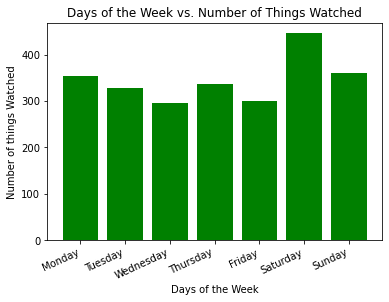

In [47]:
import matplotlib.pyplot as plt
days_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_freq = [0] * 7
for day in range(len(days_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == days_list[day]]
    frequency = temp_df["Things Watched"].sum()
    days_freq[day] = frequency

plt.figure()
plt.bar(days_list, days_freq, color = "green")
plt.xticks(rotation = 25, ha = "right")
plt.xlabel("Days of the Week")
plt.ylabel("Number of things Watched")
plt.title("Days of the Week vs. Number of Things Watched")

Here we can see that the distribution is relatively the same. However the weekend does seem to be slightly larger, especially Saturday. Lets graph the weekend (Saturday, Sunday) compared to weekdays (Monday, Tuesday, Wednesday, Thursday, Friday).

### Day Means Visualization

Text(0.5, 1.0, 'Days of the Week vs. Average Number of Things Watched')

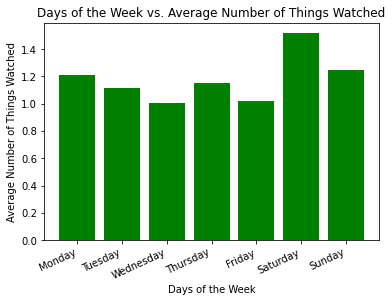

In [48]:
days_means = [0] * 7
for day in range(len(days_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == days_list[day]]
    frequency = temp_df["Things Watched"].mean()
    days_freq[day] = frequency

plt.figure()
plt.bar(days_list, days_freq, color = "green")
plt.xticks(rotation = 25, ha = "right")
plt.xlabel("Days of the Week")
plt.ylabel("Average Number of Things Watched")
plt.title("Days of the Week vs. Average Number of Things Watched")

Weekday = 1612.0
Weekend = 806.0


Text(0.5, 1.0, 'Weekend or Weekday vs. Number of Things Watched')

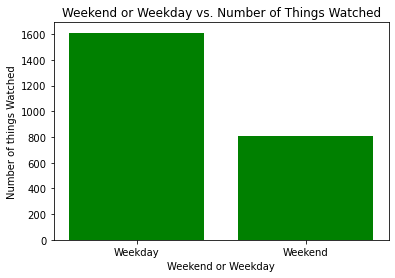

In [49]:
weekend_list = ["Saturday", "Sunday"]
weekend_freq = 0
weekday_freq = 0
weekday_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
frequency = 0
for day in range(len(weekend_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekend_list[day]]
    frequency = temp_df["Things Watched"].sum()
    weekend_freq += frequency
frequency = 0
for day in range(len(weekday_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekday_list[day]]
    frequency = temp_df["Things Watched"].sum()
    weekday_freq += frequency
print("Weekday =", weekday_freq)
print("Weekend =", weekend_freq)

plt.figure()
plt.bar(["Weekday", "Weekend"], [weekday_freq, weekend_freq], color = "green")
plt.xlabel("Weekend or Weekday")
plt.ylabel("Number of things Watched")
plt.title("Weekend or Weekday vs. Number of Things Watched")


Here we can see that the Weekdays have a slightly higher frequency of things watched. However, this is the combonation of 4 different days in the week compared to my classification of the weekend with only 3 days. Hinting to the fact that the weekend despite having less days might have had a higher frequency on average. 

### Visualizing the Months and Things Watched

Text(0.5, 1.0, 'Month vs. Average')

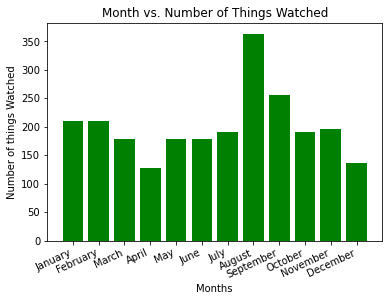

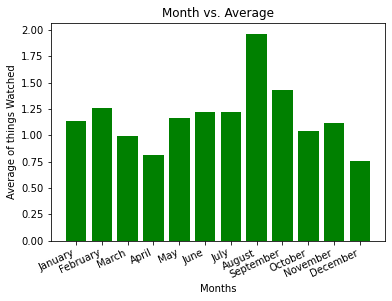

In [50]:
month_list = ["January", "February", "March", "April", "May", "June", "July", "August", "September","October", "November", "December"]
month_freq = [0] * 12

for month in range(len(month_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Month"] == month_list[month]]
    frequency = temp_df["Things Watched"].sum()
    month_freq[month] = frequency

plt.figure()
plt.bar(month_list, month_freq, color = "green")
plt.xticks(rotation = 25, ha = "right")
plt.xlabel("Months")
plt.ylabel("Number of things Watched")
plt.title("Month vs. Number of Things Watched")

mean_months = [0] * 12
for month in range(len(month_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Month"] == month_list[month]]
    frequency = temp_df["Things Watched"].mean()
    mean_months[month] = frequency

plt.figure()
plt.bar(month_list, mean_months, color = "green")
plt.xticks(rotation = 25, ha = "right")
plt.xlabel("Months")
plt.ylabel("Average of things Watched")
plt.title("Month vs. Average")

Here we can see that during the month of Augutst I tend to watch a lot more often than I do during any other month. I believ this is due to the fact that during that time I am usually off school, meaning that I have less responsibilities causing me to watch more on Netflix.

### Visualizing Things Watched per day based on Weather Descriptions
This will allow us to see if there is a corelation between the weather for the day and the number of things watched.

Text(0.5, 1.0, 'Description of the Weather vs. # of Things Watched')

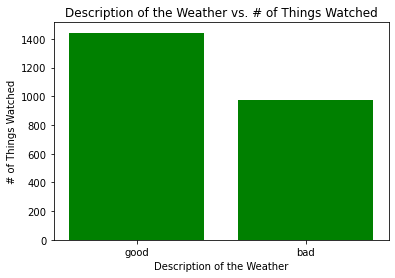

In [51]:
descr_list = ["good", "bad"]
freq_list = [0] * 2
for descr in range(len(descr_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Wthr Desc."] == descr_list[descr]]
    frequency = temp_df["Things Watched"].sum()
    freq_list[descr] = frequency
plt.figure()
plt.bar(descr_list, freq_list, color = "green")
plt.xlabel("Description of the Weather")
plt.ylabel("# of Things Watched")
plt.title("Description of the Weather vs. # of Things Watched")

Text(0.5, 1.0, 'Description of the Weather vs. Average # of Things Watched')

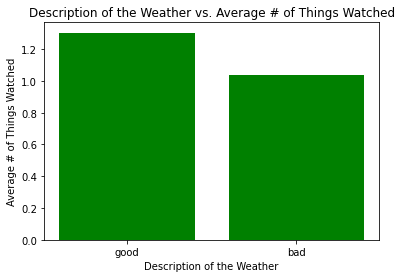

In [52]:
mean_list = [0] * 2
for descr in range(len(descr_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Wthr Desc."] == descr_list[descr]]
    frequency = temp_df["Things Watched"].mean()
    mean_list[descr] = frequency
plt.figure()
plt.bar(descr_list, mean_list, color = "green")
plt.xlabel("Description of the Weather")
plt.ylabel("Average # of Things Watched")
plt.title("Description of the Weather vs. Average # of Things Watched")

Based on the two previous graphs we can see that while overall I watched more things when the weather was classified as bad, I seemed to watch more things on average when the weather was good. A possible explanantion to this could be the Summer months where I tend not to have as many responsibilities so I watch more, and since in the Summer, even in Washington, the weather is usually good during that time. Thus, causing the average number of things watched for good weather days be greater than that of the bad weather days.

## Hypothesis Testing 
Based on the visualizations of the data I have gathered on myself I believe some hypothesis tests we should conduct include the comparisons:
* Saturdays average # number of things watched compared to the other days of the week 
* The average number of things watched during the week and then the Weekend
* The average number of things watched on a good weather day compared to a bad one 

Now each of these test will be a dependent two sample test of the means since the number of things watched is dependent on the day of the week and then the weather. Plus, they are two sample tests since the data has been collected on my own Netflix Viewing history and on differing days.

### Is the number of things watched on average for the day of the Saturday higher than that of a Weekday?
Using a significance level of .025 we are going to do a 2 sample dependent test comparing the mean number of things watched on Saturdays and then any given Weekday. However since this is a dependent test the number of instances need to be the same and since there arent equal instances of each day or number of points collected for each of these samples we need to slected a finite amount from the data to make them equal. So to do this I will start at an index of 70 and then choose 114 from that point on since we need to equally diivide the number of things watched coming from every day other than Saturday.
##### Calculations
Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Other} >= \mu_{Saturday}$
* $H_{1} = \mu_{Other} < \mu_{Saturday}$

Level of Significance:
* $\alpha = .025$

Test Statistic:
* will be using a t-test:
$$t = \frac{\overline{d} - \mu_{d}}{s_{\overline{d}}}$$

Degrees Freedom:
* $df = 100 - 1 = 99$

T-Critical:
* $t_{crit} = 1.960$

Decision Rule:
* If the value of t is larger than that of $t_{crit}$ then we will have enough evidence to reject the null hypothesis. Meaning that the average number of things Watched is higher on a Saturday than the average number of things watched on any other day .

In [53]:
from scipy import stats


otherday_things_list = list()
other_days_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"]

for weekday in range(len(other_days_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == other_days_list[weekday]]
    temp_ser = temp_df["Things Watched"].iloc[70:89].copy()
    for value in temp_ser:
        otherday_things_list.append(value)
otherday_ser = pd.Series(otherday_things_list)


saturday_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == "Saturday"]
saturday_ser = saturday_df["Things Watched"].iloc[0:114]

print("Saturday mean =", saturday_ser.mean())
print("Otherday mean =", otherday_ser.mean())

t, pval = stats.ttest_rel(saturday_ser, otherday_ser)
pval /= 2
alpha = .025

print("t =", t, "pval =", pval)

if pval < alpha:
    print("reject H0")
else:
    print("do not reject H0")

Saturday mean = 1.4473684210526316
Otherday mean = 0.7543859649122807
t = 2.56229897900176 pval = 0.005856878537432122
reject H0


Based off of the information above we have enough evidence to reject the null hypothesis meaning we have to accept that on average that on Saturdays I tend to watch more or the same amount than on any other day

### Is the number of things watched on average for the Weekend higher than that of a Weekday?
Using a significance level of .1 we are going to do a 2 sample dependent test comparing the mean number of things watched on the weekend higher then the weekday. However since the number of weekdays and and the number of days in a weekend the number of instances will be unequal. So to combat this we are going to only use the first 100 values from the larger dataset.
##### Calculations
Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{Week} >= \mu_{Weekend}$
* $H_{1} = \mu_{Week} < \mu_{Weekend}$

Level of Significance:
* $\alpha = .1$

Test Statistic:
* will be using a t-test:
$$t = \frac{\overline{d} - \mu_{d}}{s_{\overline{d}}}$$

Degrees Freedom:
* $df = 100 - 1 = 99 $

T-Critical:
* $t_{crit} = 1.282 $

Decision Rule:
* If the value of t is larger than that of $t_{crit}$ then we will have enough evidence to reject the null hypothesis. Meaning that the average number of things Watched is higher on the Weekend than the average number of things watched on a weekday .

In [54]:
weekend_sums_list = list()
weekday_sums_list = list()

for weekend in range(len(weekend_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekend_list[weekend]]
    temp_ser = temp_df["Things Watched"].copy()
    for value in temp_ser:
        weekend_sums_list.append(value)
weekend_ser = pd.Series(weekend_sums_list)
    
for week in range(len(weekday_list)):
    temp_df = fully_merged_df.loc[fully_merged_df["Day of Week"] == weekday_list[week]]
    temp_ser = temp_df["Things Watched"].copy()
    for value in temp_ser:
        weekday_sums_list.append(value)
weekday_ser = pd.Series(weekday_sums_list)
weekday_ser = weekday_ser.iloc[0:100]
weekend_ser = weekend_ser.iloc[0:100]
print("Weekday mean = ",weekday_ser.mean())
print("Weekend mean = ",weekend_ser.mean())

print(len(weekday_ser))
print(len(weekend_ser))

t, pval = stats.ttest_rel(weekend_ser, weekday_ser, nan_policy="omit")
pval /= 2
alpha = .1

print("t =", t, "pval =", pval)

if pval < alpha:
    print("reject H0")
else:
    print("do not reject H0")

Weekday mean =  0.89
Weekend mean =  1.41
100
100
t = 1.7551775212494163 pval = 0.04116118565019316
reject H0


Now based on the information above we can reject the null hypothesis. So , we have to accept the fact that I tend to watch more on average on the weekend compared to the week

### Is the number of things watched on a day classified with good weather greater than that classified with bad weather?
Using a significance level of .1 we are going to do a 2 sample dependent test comparing the mean number of things watched on the weekend higher then the weekday. However, the number of bad days and and the number of good days  will be unequal. So to combat this we are going to only use the first 100 values from the larger dataset.
##### Calculations
Identifying null and alternative Hypotheses:
* $H_{0} = \mu_{bad} >= \mu_{good}$
* $H_{1} = \mu_{bad} < \mu_{good}$

Level of Significance:
* $\alpha = .1$

Test Statistic:
* will be using a t-test:
$$t = \frac{\overline{d} - \mu_{d}}{s_{\overline{d}}}$$

Degrees Freedom:
* $df = 100 - 1 = 99 $

T-Critical:
* $t_{crit} = 2.576 $

Decision Rule:
* If the value of t is larger than that of $t_{crit}$ then we will have enough evidence to reject the null hypothesis. Meaning that the average number of things watched is higher on the good days than the average number of things watched on a bad day.

In [55]:
bad_df = fully_merged_df.loc[fully_merged_df["Wthr Desc."] == "bad"]
good_df = fully_merged_df.loc[fully_merged_df["Wthr Desc."] == "good"]
bad_ser = bad_df["Things Watched"].iloc[0:100].copy()
good_ser = good_df["Things Watched"].iloc[0:100].copy()

print("Bad weather mean:", bad_ser.mean())
print("Good Weather mean:", good_ser.mean())

t, pval = stats.ttest_rel(good_ser,bad_ser,nan_policy="omit")

pval /= 2
alpha = .1

print("t =", t, "pval =", pval)

if pval < alpha:
    print("reject H0")
else:
    print("do not reject H0")


Bad weather mean: 0.85
Good Weather mean: 1.16
t = 0.7707805286499967 pval = 0.2213363271397733
do not reject H0


This means that this test does not gives us enough evidence to reject the null hypothesis. MEaning we have to accept the fact that the average number of things watched on days classified with bad weather is greater than or equal to that of a day classified with good weather 

## Classification
Next we are going to develop models to predict the number of things watched for unseen values in our dataset. We are going to do this by developing a KNN model and a Decision Tree Model, comparing the results of each of these models to decide which to use when predicting unseen values.

### Developing a KNN model 
the K nearest neighbors is an algorithm that normalizes each numerical value in the dataset, and the unseen value then finds the n closest values to the unseen instance, and using those closest neighbors, finding the most frequent of the unseen category we are trying to predict as our prediction.

However to do this we first need to convert each of the categorical columns to numeric using Label Encoding

In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["good", "bad"])
fully_merged_df["Wthr Desc."] = le.transform(fully_merged_df["Wthr Desc."])

le_2 = LabelEncoder()
le_2.fit(month_list)
fully_merged_df["Month"] = le_2.transform(fully_merged_df["Month"])

le_3 = LabelEncoder()
le_3.fit(days_list)
fully_merged_df["Day of Week"] = le_3.transform(fully_merged_df["Day of Week"])

print(fully_merged_df)


             tavg   tmin   tmax  prcp  Day of Week  Month  Wthr Desc.  \
Date                                                                    
2016-07-30  67.64  60.08  77.00   0.0            2      5           1   
2016-07-31  65.12  57.92  73.04   0.0            3      5           1   
2016-08-01  64.40  55.04  77.00   0.0            1      1           1   
2016-08-02  63.68  59.00  71.06   0.0            5      1           1   
2016-08-03  66.56  60.08  75.02   0.0            6      1           1   
...           ...    ...    ...   ...          ...    ...         ...   
2022-04-05  45.68  39.20  53.60   0.8            5      0           0   
2022-04-06  47.84  35.60  60.80   0.0            6      0           0   
2022-04-07  57.74  44.60  71.60   0.0            4      0           1   
2022-04-08  50.18  44.60  59.00  10.2            0      0           0   
2022-04-09  43.52  37.40  48.20   6.4            2      0           0   

            Things Watched  
Date                 

#### Predicting Things Watched:

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = fully_merged_df.drop("Things Watched", axis = 1)
y = fully_merged_df["Things Watched"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

accuracy = knn_clf.score(X_test, y_test) 
print("accuracy = ", accuracy)


accuracy =  0.5477582846003899


#### Predicitng Day of the Week:


In [58]:
X = fully_merged_df.drop("Day of Week", axis = 1)
y = fully_merged_df["Day of Week"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

accuracy = knn_clf.score(X_test, y_test) 
print("accuracy = ", accuracy)

accuracy =  0.14035087719298245


#### Predicting Month:

In [59]:
X = fully_merged_df.drop("Month", axis = 1)
y = fully_merged_df["Month"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

accuracy = knn_clf.score(X_test, y_test) 
print("accuracy = ", accuracy)

accuracy =  0.24366471734892786


#### Predicitng Weather Description:

In [60]:
X = fully_merged_df.drop("Wthr Desc.", axis = 1)
y = fully_merged_df["Wthr Desc."].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)

accuracy = knn_clf.score(X_test, y_test) 
print("accuracy = ", accuracy)

accuracy =  0.9727095516569201


From these 3 models developed we can see the column that we can predict the most accurately is the Weather Description with 97%. This is then followed by the number of things watched (54%), the Month (24%), and then finally the day of the week (14%). However, I believe as to the reason the highest accuracy is with the Weather Description is because there are only 2 different categories the algorithm can predict. Meaning that without any insight or training the algorith already has a 50 percent chance of selecting the right descriptor. This preception is then fortified when you look at how many options the other models are predicting. For instance, with the day of the the algorithm has a 1/7th chance of selecting the right option outright and then for predicting the month the algorithm has a 1/12th chance. Additionally, a reason as to why some have a higher accuracy than others is because, especially for the months, there is a much higher pattern or correlation between the months, weather, and then in turn the number of things watched compared to the day of the week where the weather/seasons can change dramatically from week too week. Thus, making it harder for the algorithm to predict accurately.  

### Developing the Decision Tree Classifier

#### Predicting Things Watched:

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

X = fully_merged_df.drop("Things Watched", axis = 1)
y = fully_merged_df["Things Watched"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
tree_clf = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_clf.fit(X_train, y_train)
y_predicted = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("accuracy", accuracy)


accuracy 0.6120857699805068


#### Predicting Day of Week:

In [62]:
X = fully_merged_df.drop("Day of Week", axis = 1)
y = fully_merged_df["Day of Week"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
tree_clf = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_clf.fit(X_train, y_train)
y_predicted = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("accuracy", accuracy)

accuracy 0.14814814814814814


#### Predicting Month:

In [63]:
X = fully_merged_df.drop("Month", axis = 1)
y = fully_merged_df["Month"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
tree_clf = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_clf.fit(X_train, y_train)
y_predicted = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("accuracy", accuracy)

accuracy 0.30994152046783624


#### Predicting Weather Description:

In [64]:
X = fully_merged_df.drop("Wthr Desc.", axis = 1)
y = fully_merged_df["Wthr Desc."].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
tree_clf = DecisionTreeClassifier(random_state=0, max_depth=3)
tree_clf.fit(X_train, y_train)
y_predicted = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("accuracy", accuracy)

accuracy 1.0


When using the same type of train test splits on this data for a decision tree instead of a knn model we see that for every single prediction the accuracy increased. Most notably the accuracy for the algorithm when predicting the Weather description went from 97% to 100% meaning that within our training set this model predictied the right y value every single time. Highlighting the fact that there is a big correlation between the weather data collected, and the number of things watched on a certain day. 

## Ethics and Conclusion

From this Exploratory Data anlysis of my own Netflix data, the day of the week, the month, and the weather, of when something was watched we can see that there are definitely viewing habits based on these factors. Then, after the classification done we can see that algorithms/classification models can predict my habits decently well. Predicting most values within my fully combined dataset decently accurately. Highlighting the fact that my watching habits are quite predictable. Meaning that any data scientist that works with Netflix, who in turn has access to this data for every single user on the site, can predict and create algorithms to maximize a users watchtime based on them. For instance, a way in which they could pry and motivate a user like me to watch something on Netflix would be to send my account some kind of notification on days where I tend not to watch as much. For example, with my own data they could try and send more notifications during the week since I tend to watch more anyways on Saturdays. To add on, they could send notifications when it is a day classified in my location with bad weather to send a notification like, `Time to stay inside, bundle up, and binge your favorite shows `, tempting me, quite effectively, to open up the app and start watching anything and everything. 